In [116]:
import ast
import random
import pickle
import json

import pandas as pd
import numpy as np
from numpy.linalg.linalg import LinAlgError
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from matplotlib_venn import venn2, venn3, venn3_circles
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import dateutil
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2

In [79]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

In [80]:
ogtt = pd.read_csv(r'..\data\processed\OGTT_fixed_effects_lm_results.csv', index_col=0)
bg = pd.read_csv(r'..\data\processed\Weekly_BG_fixed_effects_lm_results.csv', index_col=0)

In [7]:
# feat = 'unknown_108179688_13387'
feature = "l_218"
def get_lme_params(feature, lme_df):
    """
    Return the three points that define each of Random and Fasted best fit lines for plotting in plt.scatter()
    in the form {'RBG': [[normal_x, impaired_x, diabetic_x], [normal_y, impaired_y, diabetic_y]],
                 'FBG': [[normal_x, impaired_x, diabetic_x], [normal_y, impaired_y, diabetic_y]]}
    """
    # ast = Abstract Syntax Tree
    # This trick reads in an incorrectly formatted dictionary that uses  ''  instead of ""
    # https://stackoverflow.com/questions/988228/convert-a-string-representation-of-a-dictionary-to-a-dictionary
    params = ast.literal_eval(lme_df.loc[feature]['full_model_params'])
    
    diabetic_fbg = params['Intercept']
    diabetic_rbg = params['Intercept'] + params['bg_type[T.RBG]']

    impaired_fbg = diabetic_fbg + params['glucose_tolerance[T.impaired]']
    impaired_rbg = diabetic_rbg + params['glucose_tolerance[T.impaired]'] + params['glucose_tolerance[T.impaired]:bg_type[T.RBG]']

    normal_fbg = diabetic_fbg + params['glucose_tolerance[T.normal]']
    normal_rbg = diabetic_rbg + params['glucose_tolerance[T.normal]'] + params['glucose_tolerance[T.normal]:bg_type[T.RBG]']
    
    return {'RBG': [[0, 1, 2], [normal_rbg, impaired_rbg, diabetic_rbg]],
            'FBG': [[0, 1, 2], [normal_fbg, impaired_fbg, diabetic_fbg]]}  
get_lme_params(feature, ogtt)

KeyError: 'glucose_tolerance[T.impaired]'

In [146]:
ogtt_values = animal_phenotypes.loc[animal_phenotypes['lcms_sampled'], 'OGTT (AUC)']
min_ogtt, max_ogtt = min(ogtt_values), max(ogtt_values)

def get_model_params(feature, df): 
    params = ast.literal_eval(df.loc[feature]['full_model_params'])
    interceptfbg = params['Intercept']
    interceptrbg = interceptfbg + params['bg_type[T.RBG]']
    minfbg = interceptfbg + params['ogtt'] * min_ogtt
    minrbg = interceptrbg + params['ogtt'] * min_ogtt + params['ogtt:bg_type[T.RBG]'] * min_ogtt
    maxfbg = interceptfbg + params['ogtt'] * max_ogtt
    maxrbg = interceptrbg + params['ogtt'] * max_ogtt + params['ogtt:bg_type[T.RBG]'] * max_ogtt
    
    return {'RBG': [[min_ogtt, max_ogtt], [minrbg, maxrbg]],
            'FBG': [[min_ogtt, max_ogtt], [minfbg, maxfbg]]}  
test = get_model_params('l_222', ogtt)
test

{'RBG': [[846.75, 2321.25], [19.89694449817288, 20.80537257143588]],
 'FBG': [[846.75, 2321.25], [18.95011268332485, 19.465095279545206]]}

In [151]:
ap.loc[ap['lcms_sampled']].filter(regex='^RBG')

,RBGweek4,RBGweek8,RBGweek9,RBGweek10,RBGweek11,RBGweek12
animal,,,,,,
1060,71.0,225.000000,83.000000,206.0,221.0,193.000000
1062,78.0,256.500000,250.500000,139.5,248.5,90.333333
1074,70.0,232.500000,203.500000,205.5,225.5,139.500000
1076,96.0,387.666667,281.000000,349.0,391.5,435.500000
1082,90.0,272.000000,339.500000,330.5,413.0,537.500000
1091,84.0,108.500000,86.000000,71.5,78.0,68.000000
1092,75.0,76.000000,70.500000,59.0,58.0,44.000000
1093,72.0,82.000000,83.000000,69.5,65.5,65.000000
1101,73.0,459.500000,342.666667,352.0,505.5,NaN


In [198]:
data.sort_values('fdr corrected pval effect of sampling').iloc[0].name

'm_9'

In [207]:
data['Unique ID']

i
l_0           unknown_679.05463_0.536
l_1            unknown_641.1087_0.537
l_2           unknown_951.15973_0.541
l_3           unknown_329.03067_0.542
l_4           unknown_969.13147_0.544
                     ...             
m_169          unknown_174.00102_9.94
m_213         unknown_187.04097_9.971
m_24     DL-Lactic Acid_89.02331_9.99
m_505           unknown_313.051_9.991
m_441         unknown_300.11152_9.992
Name: Unique ID, Length: 1727, dtype: object

In [228]:
ogtt

,gluc_pval,sampling_pval,cross_pval,fdr_gluc_qval,fdr_sampling_qval,fdr_cross_qval,full_model_ll,no_gluc_tol_ll,no_feeding_ll,no_cross_ll,full_model_params,no_gluc_tol_params,no_feeding_params,no_cross_params
feature_name,,,,,,,,,,,,,,
l_0,0.341121,3.670408e-02,0.822562,0.432856,5.674838e-02,0.887299,-50.703556,-51.779073,-54.008423,-50.728700,"{'Intercept': 23.67567725361177, 'bg_type[T.RB...","{'Intercept': 23.24699628316563, 'bg_type[T.RB...","{'Intercept': 23.810235575407763, 'ogtt': -0.0...","{'Intercept': 23.6186842260093, 'bg_type[T.RBG..."
l_1,0.593557,9.025863e-01,0.684049,0.666931,9.250840e-01,0.796596,-72.113038,-72.634661,-72.215529,-72.195840,"{'Intercept': 24.670772845133506, 'bg_type[T.R...","{'Intercept': 24.476783695839988, 'bg_type[T.R...","{'Intercept': 24.839267002225867, 'ogtt': -0.0...","{'Intercept': 24.81861527245705, 'bg_type[T.RB..."
l_2,0.676955,2.880545e-01,0.518138,0.735747,3.528157e-01,0.662387,-58.680346,-59.070496,-59.924952,-58.889145,"{'Intercept': 23.618616065261367, 'bg_type[T.R...","{'Intercept': 23.60640305021915, 'bg_type[T.RB...","{'Intercept': 23.55175999673154, 'ogtt': 0.000...","{'Intercept': 23.43074061299636, 'bg_type[T.RB..."
l_3,0.437841,1.141631e-01,0.506729,0.529850,1.573501e-01,0.652350,-44.849866,-45.675765,-47.019994,-45.070274,"{'Intercept': 27.267338988868747, 'bg_type[T.R...","{'Intercept': 26.85818465005638, 'bg_type[T.RB...","{'Intercept': 27.246931101792473, 'ogtt': -0.0...","{'Intercept': 27.114034990066614, 'bg_type[T.R..."
l_4,0.512260,6.257205e-02,0.251348,0.594938,9.267747e-02,0.398603,-59.173591,-59.842514,-61.945027,-59.831488,"{'Intercept': 22.73239618202266, 'bg_type[T.RB...","{'Intercept': 22.438824645125887, 'bg_type[T.R...","{'Intercept': 22.572092640593894, 'ogtt': 2.69...","{'Intercept': 22.39488757084885, 'bg_type[T.RB..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_169,0.000136,1.912550e-01,0.843401,0.000658,2.472286e-01,0.899107,18.840335,9.938298,17.186188,18.820823,"{'Intercept': 25.24574049909552, 'bg_type[T.RB...","{'Intercept': 24.898844984376986, 'bg_type[T.R...","{'Intercept': 25.303336623618655, 'ogtt': -0.0...","{'Intercept': 25.26149333526538, 'bg_type[T.RB..."
m_213,0.638285,2.441476e-04,0.836622,0.702013,5.555242e-04,0.894088,-121.868945,-122.317916,-130.186682,-121.890207,"{'Intercept': 21.072754787526677, 'bg_type[T.R...","{'Intercept': 20.12865195340113, 'bg_type[T.RB...","{'Intercept': 21.942605387044438, 'ogtt': -0.0...","{'Intercept': 20.90115826615619, 'bg_type[T.RB..."
m_24,0.297445,3.718213e-04,0.332515,0.388275,8.211449e-04,0.479840,-40.549320,-41.761846,-48.446417,-41.018859,"{'Intercept': 27.516619949020836, 'bg_type[T.R...","{'Intercept': 27.042691925697746, 'bg_type[T.R...","{'Intercept': 27.561983213596037, 'ogtt': -0.0...","{'Intercept': 27.307906307536467, 'bg_type[T.R..."


Plasmanyl-PC_O-34:4_740.56061_8.327
l_289


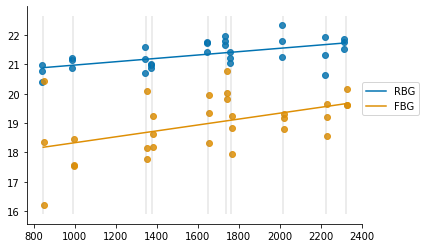

In [253]:
animal_ogtts = ap.loc[ap['lcms_sampled']].filter(regex='OGTT \(AUC\)')

# feature = random.sample(list(data.index), 1)[0]
# feature = 'm_548'
feature = data.loc[(~data['Unique ID'].str.contains('unknown')) & (data['Type'] == 'lipid')]\
              .sort_values('fdr corrected pval effect of sampling').iloc[22] 
print(feature['Unique ID'])
feature = feature.name
print(feature)

fig, ax = plt.subplots()
params = get_model_params(feature, ogtt)

for bg_type, bg_color, offset in zip(['RBG', 'FBG'], [colors['RBG'], colors['FBG']], [-5, 5]):
    ax.plot(params[bg_type][0], params[bg_type][1], label=bg_type, color=bg_color)
    for animal in animals_used:
        gluc_tol = animal_tol[animal]
        animal_ogtt = animal_ogtts.loc[animal]
        df = data.loc[feature, data.filter(regex=str(animal)).filter(regex=bg_type).columns]
        plt.scatter(np.array([animal_ogtt]*3) + offset, df, color=bg_color, alpha=0.85)
        
plt.legend(loc=(1, 0.5))
ylim = ax.get_ylim()
for ogtt_value in animal_ogtts.iloc[:, 0]:
    plt.vlines(x=ogtt_value, ymin=ylim[0], ymax=ylim[1], color='gray', alpha=0.2)
# plt.xticks(animal_ogtts.iloc[:, 0])
sns.despine()

In [133]:
data.loc[feature, fbg_cols]

1076_10_FBG    22.702338
1062_8_FBG     22.346725
1093_9_FBG     22.629048
1091_10_FBG     22.69058
1082_10_FBG    22.860677
1101_9_FBG     22.902586
1074_10_FBG    22.671558
1076_9_FBG      21.28545
1092_9_FBG     22.791217
1074_8_FBG     23.158195
1082_9_FBG      22.82536
1060_8_FBG     22.065355
1060_10_FBG    22.664376
1101_10_FBG    23.080772
1093_8_FBG     22.665739
1062_9_FBG     22.588667
1092_8_FBG     22.013075
1062_10_FBG    22.137143
1060_9_FBG     22.534742
1091_9_FBG     23.979612
1102_9_FBG     22.721014
1093_10_FBG    22.923587
1101_8_FBG     21.738842
1102_8_FBG     22.481738
1082_8_FBG     21.812044
1076_8_FBG     22.709921
1091_8_FBG     22.690034
1092_10_FBG    22.752286
1102_10_FBG    22.977016
1074_9_FBG     23.104235
Name: m_340, dtype: object

In [59]:
f.filter(regex='1076').mean(axis=1)

i
l_0      22.679690
l_1      23.594023
l_2      23.103339
l_3      26.243724
l_4      21.424737
           ...    
m_169    24.689008
m_213    20.310409
m_24     26.922636
m_505    19.534830
m_441    22.116884
Length: 1727, dtype: float64

In [63]:
d = {'RBG': {}, 'FBG': {}}

for animal in animals_used:
    for df, bg_type in zip([f, r], ['FBG', 'RBG']):
        bg_type_animal_mean = df.filter(regex=str(animal)).mean(axis=1)
        d['RBG'][animal] = bg_type_animal_mean 

In [75]:
animal_ogtt = {animal: ogtt for animal, ogtt in zip(animal_phenotypes['animal'], animal_phenotypes['OGTT (AUC)'])}
animal_ogtt

{1060: 1761.75,
 1061: 1674.8,
 1062: 1648.75,
 1063: nan,
 1074: 1350.25,
 1075: 3365.0,
 1076: 2321.25,
 1080: nan,
 1081: 2354.75,
 1082: 2224.75,
 1091: 846.75,
 1092: 1377.95,
 1093: 993.0,
 1094: 842.75,
 1095: nan,
 1096: 1401.25,
 1100: nan,
 1101: 2015.75,
 1102: 1738.25}

In [76]:
d['RBG'][1101]['l_0']

23.527160843441468

In [77]:
metab_ogtt_animal = {}
for metab in data.index:
    metab_ogtt_animal[metab] = 
    

l_0
l_1
l_2
l_3
l_4
l_5
l_6
l_7
l_8
l_9
l_10
l_11
l_12
l_13
l_14
l_15
l_16
l_17
l_18
l_19
l_20
l_21
l_24
l_22
l_23
l_25
l_26
l_28
l_27
l_29
l_30
l_33
l_31
l_32
l_35
l_34
l_36
l_37
l_38
l_39
l_40
l_41
l_42
l_43
l_44
l_45
l_46
l_47
l_48
l_49
l_50
l_51
l_52
l_53
l_54
l_55
l_56
l_57
l_58
l_59
l_60
l_61
l_62
l_63
l_64
l_65
l_66
l_67
l_68
l_69
l_70
l_71
l_72
l_73
l_74
l_75
l_77
l_76
l_79
l_78
l_80
l_81
l_82
l_83
l_84
l_85
l_86
l_87
l_88
l_89
l_90
l_91
l_92
l_93
l_94
l_95
l_96
l_97
l_98
l_99
l_100
l_101
l_102
l_103
l_104
l_105
l_106
l_107
l_108
l_109
l_110
l_111
l_112
l_113
l_114
l_115
l_116
l_117
l_120
l_119
l_118
l_121
l_122
l_123
l_124
l_125
l_126
l_127
l_128
l_129
l_130
l_131
l_132
l_133
l_134
l_135
l_137
l_136
l_138
l_139
l_140
l_142
l_141
l_143
l_144
l_145
l_146
l_147
l_148
l_149
l_150
l_151
l_152
l_153
l_154
l_155
l_156
l_157
l_158
l_159
l_161
l_162
l_160
l_163
l_164
l_165
l_166
l_167
l_168
l_169
l_170
l_171
l_172
l_173
l_174
l_175
l_176
l_177
l_178
l_179
l_180
l_181
l_182
l_183
l_184


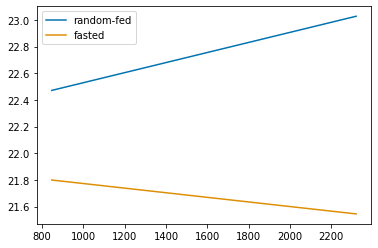

In [42]:
feature = 'l_557'
test = get_model_fits(feature, ogtt)

plt.plot(test['RBG'][0], test['RBG'][1], c=colors['RBG'], label='random-fed')
plt.plot(test['FBG'][0], test['FBG'][1], c=colors['FBG'], label='fasted')


for bg_type in ['RBG', 'FBG']:
    for animal in animals_used:
        plt.scatter()
    

plt.scatter()

plt.legend()